# [PTM] Section 4

## 8. 컨볼루선을 활용한 일반화
- 이전에는, 선형 계층에 존재하는 최적화를 위해 활용 가능한 여러 파라미터의 도움으로 단순 신경망을 만듬
- 특성을 일반화해 훈련하기 보다는 훈련셋을 암기하는 성향

### 8.1 컨볼루션
- `n_outpu_features * n_input_features` -> 이미지의 각 채널은, 가중치 집합과 모든 픽셀의 총합을 각각의 출력 피처에 대해 계산
- 인근 픽셀의 배열 방식을 살펴봐야 하며, 스핏파이어 등장시 관심이 없음

#### 8.1.1 컨볼루션의 역할
- 평행이동 불변성(translation invariance): 지역화된 패턴이 이미지의 어떤 위치에 있더라도 동일하게 출력에 영향을 주는 성질
- 컨볼루션(convolution): 이미지에 대해 지역적인, 평생이동 불변성을 보장하는 선형 연산
- 이산 컨볼루션(discrete convolution, 연속된 버전도 존재하긴 함)은 2차원 이미지에 가중치 행렬을 스칼라곱을 수행하는 것
- 가중치 행렬은 커널(kernel)이라 부름

### 8.2 컨볼루션 사용해보기

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import collections

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.set_printoptions(edgeitems=2)
torch.manual_seed(123)

import collections

c:\USERS\SPEC3\ANACONDA3\ENVS\NN\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
conv = nn.Conv2d(3, 16, kernel_size=3)
conv

Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))

In [3]:
conv.weight.shape, conv.bias.shape

(torch.Size([16, 3, 3, 3]), torch.Size([16]))

In [4]:
class_names = ['airplane','automobile','bird','cat','deer', 'dog','frog','horse','ship','truck']

In [5]:
from torchvision import datasets, transforms
data_path = './data-unversioned/p1ch6/'
cifar10 = datasets.CIFAR10(
    data_path, train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

Files already downloaded and verified


In [6]:
cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

Files already downloaded and verified


In [7]:
label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label])
          for img, label in cifar10
          if label in [0, 2]]
cifar2_val = [(img, label_map[label])
              for img, label in cifar10_val
              if label in [0, 2]]

In [8]:
img, _ = cifar2[0]
output = conv(img.unsqueeze(0))

img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 30, 30]))

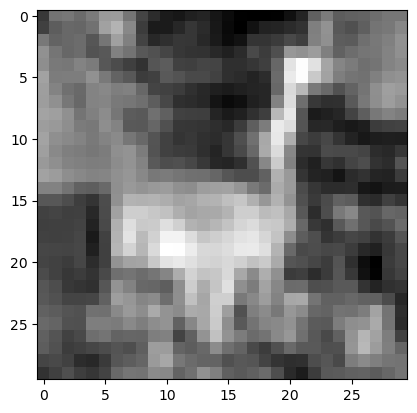

In [9]:
plt.imshow(output[0, 0].detach(), cmap="gray")
plt.show()

#### 8.2.1 경계 패딩하기


In [10]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 1, 32, 32]))

#### 8.2.2 컨볼루션으로 피처 찾아내기


In [11]:
# bias를 0으로 제거해, 교란 변수 배제
with torch.no_grad():
    conv.bias.zero_()
    
with torch.no_grad():
    conv.weight.fill_(1.0/9.0)

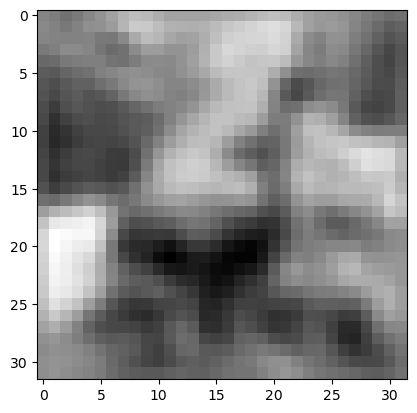

In [12]:
output = conv(img.unsqueeze(0))
plt.imshow(output[0, 0].detach(), cmap="gray")
plt.show()

각 출력 픽셀은 자신의 주변 픽셀에 대한 평균이기 때문에 출력 픽셀에서 이러한 상관관계를 반영해 픽셀 간의 변화가 부드러워짐

In [13]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)

with torch.no_grad():
    conv.weight[:] = torch.tensor([[-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0]])
    conv.bias.zero_()

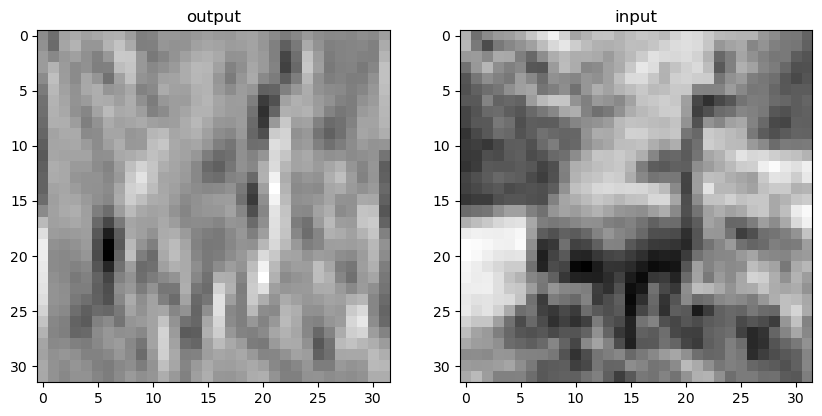

In [14]:
output = conv(img.unsqueeze(0))
plt.figure(figsize=(10, 4.8))
ax1 = plt.subplot(1, 2, 1)
plt.title('output')
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.subplot(1, 2, 2, sharex=ax1, sharey=ax1)
plt.imshow(img.mean(0), cmap='gray') 
plt.title('input')
plt.show()

#### 8.2.3 깊이와 풀링으로 한 단계 더 인식하기
- 큰 사이즈의 커널을 사용하면, 완전 연결된 아핀 변환으로 수렴해서 컨볼루션의 장점을 잃어버리게 됨
- 컨볼루션을 차례로 층층이 쌓으면서 동시에 연속적인 컨볼루션 사이의 이미지를 다운 샘플링하는 방법이 있음

##### 큰 이미지에서 작은 이미지로: 다운샘플링
- 평균 풀링(average pooling)
- 맥스 풀링(max pooling)
- 스트라이드하며 컨볼루션을 수행하되 n번째 픽셀만 계산하기

In [15]:
pool = nn.MaxPool2d(2)
output = pool(img.unsqueeze(0))

img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 3, 16, 16]))

#### 8.2.4 우리의 신경망에 적용하기

In [16]:
model = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, padding=1),
    nn.Tanh(),
    nn.MaxPool2d(2),
    nn.Conv2d(16, 8, kernel_size=3, padding=1),
    nn.Tanh(),
    nn.MaxPool2d(2),
    # ...
    nn.Linear(8*8*8, 32),
    nn.Tanh(),
    nn.Linear(32, 2)
)

In [17]:
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

### 8.3 nn.Module 서브클래싱하기
- 기존에 만들어진 모듈에서 지원하지 않는 연산이 필요할 때가 있음
- 서브클래싱을 위해서는, `forward` 함수를 정의하여 모듈로 입력을 전달하고 출력을 반환하게 해야 함
- 표준 `torch` 연산을 사용하기만 한다면, 자동미분 기능이 자동으로 역방향 경로를 만들어주기에 `nn.Module`에는 `backward`가 필요 없음

#### 8.3.1 nn.Module로 정의된 신경망


In [18]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.act2 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(8*8*8, 32)
        self.act3 = nn.Tanh()
        self.fc2 = nn.Linear(32, 2)
    def forward(self, x):
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.pool2(self.act2(self.conv2(out)))
        out = out.view(-1, 8*8*8) # 차원 정보 변경
        out = self.act3(self.fc1(out))
        out = self.fc2(out)
        return out

분류 신경망의 목적은 일반적으로 큰 수의 픽셀을 가진 이미지에서 출발해 정보를 압축해가면서 분류 클래스(확률 벡터)로 만들어가는 것  
1. 중간에 나타나는 값의 개수가 점점 줄어드는 모습에 목표한 바가 반영
   1. 컨볼루션의 채널 수가 점점 줄어들고 풀링에서 픽셀 수가 줄어들며 선형 계층에서는 입력 차원보다 낮은 수의 차원을 출력
   2. 풀링시 공간 분해능(spatial resolution) 감소가 있더라도 채널의 수는 늘어남 (전체 사이즈는 결과적으로 감소)
   3. 빠르게 정보를 축소하는 패턴은 제한된 깊이의 신경망과 작은 이미지에 대해서는 잘 동작하지만, 신경망이 깊어질수록 감소는 천천히 일어남
2. 최초의 컨볼루션에서는 입력 크기에 대해 출력 크기가 줄어들지 않음

#### 8.3.2 파이토치가 파라미터와 서브모듈을 유지하는 방법
- 생성자 안에서 `nn.Module`의 인스턴스를 할당
- 서브모듈은 탑레벨 속성이어야 함 (`list`나 `dict` 인스턴스에 들어 있으면 안됨, 필요시 `nn.ModuleList`나 `nn.ModuleDict` 사용)

In [19]:
model = Net()

numel_list = [p.numel() for p in model.parameters()]

sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

#### 8.3.3 함수형 API
- 함수형이란, 내부 상태가 없다는 의미 -> 출력값이 전적으로 입력 인자에 의존
- 파라미터가 없는 서브 모듈들은 `forward`에 등록해도 됨

In [20]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8*8*8, 32)
        self.fc2 = nn.Linear(32, 2)
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8*8*8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

언제 함수형을 사용하고 언제 모듈 API를 활용할지는 취향의 문제  

In [21]:
model = Net()
model(img.unsqueeze(0))

tensor([[ 0.0295, -0.2178]], grad_fn=<AddmmBackward0>)

### 8.4 우리가 만든 컨볼루션 신경망 훈련시키기
각 루프에서,  
1. 모델에 입력값을 넣고 (forward)
2. 손실값을 계산하고 (forward)
3. 이전 기울기값을 0으로 리셋하고
4. `loss.backward()`를 호출하여 모든 파라미터에 대한 손실값의 기울기 계산 (backward)
5. 옵티마이저를 통해 손실값을 낮추도록 파라미터를 조정

In [22]:
import datetime

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs+1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            outputs = model(imgs) # 배치 입력
            loss = loss_fn(outputs, labels)
            optimizer.zero_grad()
            loss.backward() # 역전파 수행, 신경망이 학습할 모든 파라미터에 대한 기울기를 계산
            optimizer.step() # 모델 업데이트
            loss_train += loss.item() # 에포크 동안 확인한 손실값을 모두 더함. 기울기값을 꺼내기 위해 .item()을 사용
        if epoch==1 or epoch%10==0:
            print(f"{datetime.datetime.now()} Epoch {epoch}, Training loss {loss_train/len(train_loader)}")

In [23]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)

model = Net()
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs=100,
    optimizer=optimizer,
    model=model,
    loss_fn=loss_fn,
    train_loader=train_loader
)

2023-01-01 21:06:27.294435 Epoch 1, Training loss 0.580739360706062
2023-01-01 21:06:37.780063 Epoch 10, Training loss 0.33807836501461686
2023-01-01 21:06:49.104183 Epoch 20, Training loss 0.29625455456174865
2023-01-01 21:07:00.689185 Epoch 30, Training loss 0.2711664135478864
2023-01-01 21:07:12.183251 Epoch 40, Training loss 0.25100807461199487
2023-01-01 21:07:23.647059 Epoch 50, Training loss 0.23135893507178423
2023-01-01 21:07:35.216166 Epoch 60, Training loss 0.21442529018137865
2023-01-01 21:07:46.679339 Epoch 70, Training loss 0.19844896626320613
2023-01-01 21:07:58.041631 Epoch 80, Training loss 0.18422216575616485
2023-01-01 21:08:09.422952 Epoch 90, Training loss 0.1678131561560236
2023-01-01 21:08:20.694481 Epoch 100, Training loss 0.1537676244547033


#### 8.4.1 정확도 측정
- 손실값보다 해석하기 좋은 측정 방법으로 훈련셋과 검증셋을 통한 정확도 측정을 생각해볼 수 있음

In [24]:
# 7장과 동일한 코드
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64, shuffle=False)

def validate(model, train_loader, val_loader):
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0
        
        with torch.no_grad(): # 파라미터는 업데이트하지 않음 (검증)
            for imgs, labels in loader:
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1)
                total += labels.shape[0]
                correct += int((predicted==labels).sum())
        print(f"Acc: {name}: {correct/total:.2f}")

In [25]:
validate(model, train_loader, val_loader)

Acc: train: 0.94
Acc: val: 0.89


#### 8.4.2 모델을 저장하고 불러오기

In [26]:
torch.save(model.state_dict(), data_path+"birds_vs_airplanes.pt")

`birds_vs_airplanes.pt` 파일에는 모델의 모든 파라미터가 들어 있음 -> 모델에 포함된 가중치와 편향값을 저장하고 있음 (모델 구조는 포함 X)

In [27]:
loaded_model = Net() # 모델 구조를 가져와야 함
loaded_model.load_state_dict(torch.load(data_path+"birds_vs_airplanes.pt"))

<All keys matched successfully>

#### 8.4.3 GPU에서 훈련시키기
- `Module.to`와 `Tensor.to`는 조금 다름
  - `Module.to`: 모듈 인스턴스 자체를 수정 (해당 메서드를 이용해, 모든 파라미터를 GPU로 이동 가능)
  - `Tensor.to`: 새 텐서를 반환

파라미터를 원하는 디바이스로 이동 후, Optimizer를 만드는 식의 구현을 추천

In [28]:
device = (torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"))

print(f"Training on device {device}")

Training on device cuda


In [29]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,
                                         shuffle=False)
all_acc_dict = collections.OrderedDict()

In [30]:
# 텐서를 GPU에 옮길 수 있도록 코드 수정
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_train += loss.item()

        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader)))

In [31]:
model = Net().to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs=100,
    optimizer=optimizer,
    model=model,
    loss_fn=loss_fn,
    train_loader=train_loader
)

# torch.save(model.state_dict(), data_path+"birds_vs_airplanes.pt")

2023-01-01 21:09:54.085603 Epoch 1, Training loss 0.5777876906713862
2023-01-01 21:09:55.573428 Epoch 10, Training loss 0.33688311753379313
2023-01-01 21:09:57.209615 Epoch 20, Training loss 0.2954026418886367
2023-01-01 21:09:58.953166 Epoch 30, Training loss 0.2712187937870147
2023-01-01 21:10:00.789595 Epoch 40, Training loss 0.25245457882903943
2023-01-01 21:10:02.676135 Epoch 50, Training loss 0.23556163313851994
2023-01-01 21:10:04.522945 Epoch 60, Training loss 0.22017426470852203
2023-01-01 21:10:06.370900 Epoch 70, Training loss 0.2057624204902892
2023-01-01 21:10:08.243542 Epoch 80, Training loss 0.19208600932055978
2023-01-01 21:10:10.121161 Epoch 90, Training loss 0.17869840856570346
2023-01-01 21:10:12.028724 Epoch 100, Training loss 0.16522248421504998


- 파이토치는 가중치를 저장할 때, 어떤 디바이스를 기억해뒀다가 반대로 읽어들일 때도 해당 디바이스를 사용
- 신경망을 CPU로 옮기고 저장하던지, 파일에서 읽어들인 후 CPU로 옮기던지 해야 함
- 가중치를 로딩할 때, 파이토치가 기억하는 디바이스 정보를 덮어쓰면 됨

In [32]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,
                                         shuffle=False)
all_acc_dict = collections.OrderedDict()

def validate(model, train_loader, val_loader):
    accdict = {}
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():
            for imgs, labels in loader:
                imgs = imgs.to(device=device)
                labels = labels.to(device=device)
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1) # <1>
                total += labels.shape[0]
                correct += int((predicted == labels).sum())

        print("Accuracy {}: {:.2f}".format(name , correct / total))
        accdict[name] = correct / total
    return accdict

all_acc_dict["baseline"] = validate(model, train_loader, val_loader)

Accuracy train: 0.93
Accuracy val: 0.90


In [33]:
loaded_model = Net().to(device=device)
loaded_model.load_state_dict(torch.load(data_path+"birds_vs_airplanes.pt", map_location=device))

<All keys matched successfully>

### 8.5 모델 설계
#### 8.5.1 메모리 용량 늘리기: 너비
- 신경망 계층 내의 뉴런 수 혹은 컨볼루션의 채널 수에 해당하는 값
- 모델 정의에서 하드코딩을 피하려면, 파라미터를 `init`에 전달하고 너비를 파라미터화해서 `forward` 함수에서 `view`를 호출할 때 고려

In [34]:
class NetWidth(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(16*8*8, 32)
        self.fc2 = nn.Linear(32, 2)
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out), 2))
        out = out.view(-1, 16*8*8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [35]:
# 하드코딩을 피하는 경우
class NetWidth(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1//2, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(16*8*8, 32)
        self.fc2 = nn.Linear(32, 2)
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8*8*self.n_chans1//2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [36]:
# 기존 파라미터
sum(p.numel() for p in model.parameters())

18090

In [37]:
# 신규 파라미터
model = NetWidth()

sum(p.numel() for p in model.parameters())

38386

In [38]:
model = NetWidth(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

all_acc_dict["width"] = validate(model, train_loader, val_loader)

2023-01-01 21:13:55.517562 Epoch 1, Training loss 0.5611892739298997
2023-01-01 21:13:57.284092 Epoch 10, Training loss 0.3172629364546697
2023-01-01 21:13:59.280404 Epoch 20, Training loss 0.2738924714600205
2023-01-01 21:14:01.408351 Epoch 30, Training loss 0.24248031085463845
2023-01-01 21:14:03.631287 Epoch 40, Training loss 0.2131250904528958
2023-01-01 21:14:05.780587 Epoch 50, Training loss 0.1866828964394369
2023-01-01 21:14:08.003023 Epoch 60, Training loss 0.16346318568963153
2023-01-01 21:14:10.226840 Epoch 70, Training loss 0.1422392932377803
2023-01-01 21:14:12.419625 Epoch 80, Training loss 0.12203329987823963
2023-01-01 21:14:14.610337 Epoch 90, Training loss 0.10280435439792408
2023-01-01 21:14:16.847255 Epoch 100, Training loss 0.08504004618686856
Accuracy train: 0.97
Accuracy val: 0.89


#### 8.5.2 모델이 수렴하고 일반화하도록 돕는 방법: 정규화
모델 훈련은 중요한 두 단계를 거침  
1. 최적화 단계
2. 일반화 단계

이 두 단계를 위한 수학적 도구를 모아서 정규화(regularization)이라는 이름을 붙이기도 함

##### 파라미터 제어하기: 가중치 패널티
- 일반화(generalization)를 안정적으로 수행하기 위한 첫 번째 방법
- 정규화 항을 조작해서 모델의 가중치가 상대적으로 작게 만듬
- 훈련을 통해 증가할 수 있는 크기를 제한 (큰 가중치 값에 패널티를 부과)
- L2 정규화:
  - 모든 가중치에 대한 제곱합
  - 가중치 감쇠(weight decay)
- L1 정규화: 모든 가중치의 절대값 합
  - 가중치가 희소(sparse)해지는 특징을 가짐

In [39]:
def training_loop_l2reg(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs+1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)
            
            l2_lambda = 0.001
            l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
            # l1_norm = sum(p.abs().sum() for p in model.parameters())
            loss = loss + l2_lambda * l2_norm
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            loss_train += loss.item()
            
        if epoch==1 or epoch%10==0:
            print(f"{datetime.datetime.now()} Epoch {epoch}, Training loss {loss_train/len(train_loader)}")

In [40]:
model = Net().to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop_l2reg(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
all_acc_dict["l2 reg"] = validate(model, train_loader, val_loader)

2023-01-01 21:17:02.272059 Epoch 1, Training loss 0.6083355422612209
2023-01-01 21:17:04.536727 Epoch 10, Training loss 0.36345350163377776
2023-01-01 21:17:07.119690 Epoch 20, Training loss 0.3228660639683912
2023-01-01 21:17:09.682768 Epoch 30, Training loss 0.3001404529923846
2023-01-01 21:17:12.212740 Epoch 40, Training loss 0.2821102305582375
2023-01-01 21:17:14.744036 Epoch 50, Training loss 0.2675168512353472
2023-01-01 21:17:17.275942 Epoch 60, Training loss 0.25431713025281383
2023-01-01 21:17:19.751591 Epoch 70, Training loss 0.24226275466050312
2023-01-01 21:17:22.340558 Epoch 80, Training loss 0.23128354231453246
2023-01-01 21:17:24.916748 Epoch 90, Training loss 0.2211022936994103
2023-01-01 21:17:27.445055 Epoch 100, Training loss 0.211511599884671
Accuracy train: 0.92
Accuracy val: 0.89


파이토치의 SGD 옵티마이저에는 이미 `weight_decay` 파라미터가 있고, 업데이트 동작시 가중치 감쇠를 수행  
-> 자동미분과 손실값에서 항을 누적하는 작업을 할 필요가 없음

##### 입력 하나에 너무 의존하지 않기: 드롭아웃
- 훈련을 반복할 때마다 신경망의 뉴런 출력을 랜덤하게 0으로 만드는 작업을 발생
- 매 훈련 때마다 조금씩 다른 뉴런의 토폴로지가 만들어지기 때문에 신경망이 각 입력 샘플을 암기하려는 기회를 줄이므로 과적합을 방지
- 데이터 증강과 비슷한 효과를 내기도 함 (증강은 일부, 드롭아웃은 전체)

In [41]:
class NetDropout(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv1_dropout = nn.Dropout2d(p=0.4)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, padding=1)
        self.conv2_dropout = nn.Dropout2d(p=0.4)
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = self.conv1_dropout(out)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = self.conv2_dropout(out)
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [42]:
model = NetDropout(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
all_acc_dict["dropout"] = validate(model, train_loader, val_loader)

2023-01-01 21:18:06.206950 Epoch 1, Training loss 0.5676708158793723
2023-01-01 21:18:08.375637 Epoch 10, Training loss 0.3771913461624437
2023-01-01 21:18:10.762386 Epoch 20, Training loss 0.34812240985928067
2023-01-01 21:18:13.247143 Epoch 30, Training loss 0.32809117550303224
2023-01-01 21:18:15.790865 Epoch 40, Training loss 0.3158067525572078
2023-01-01 21:18:18.310900 Epoch 50, Training loss 0.2968495054419633
2023-01-01 21:18:20.777627 Epoch 60, Training loss 0.28421627620982515
2023-01-01 21:18:23.253965 Epoch 70, Training loss 0.27738824391820627
2023-01-01 21:18:25.728643 Epoch 80, Training loss 0.26813566067795847
2023-01-01 21:18:28.203923 Epoch 90, Training loss 0.2522119077717423
2023-01-01 21:18:30.634991 Epoch 100, Training loss 0.23926594858146777
Accuracy train: 0.90
Accuracy val: 0.87


드랍아웃은 훈련 중에만 활성화 되고, 훈련이 끝난 모델에 대해서는 0의 확률을 이용

##### 활성 함수 억제하기: 배치 정규화
- 학습률을 높이면서, 훈련은 초기화에 영향을 덜 받고 정규화처럼 동작해서, 결과적으로 드랍아웃에 대한 대체 방법
- 입력 범위를 신경망의 활성 함수로 바꿔서 미니 배치가 원하는 분포를 갖게하는 것
- 활성 함수의 입력 범위를 조장하는 것이므로 선형 변환(conv 등) 뒤에 위치

In [43]:
class NetBatchNorm(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv1_batchnorm = nn.BatchNorm2d(num_features=n_chans1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1//2, kernel_size=3, padding=1)
        self.conv2_batchnorm = nn.BatchNorm2d(num_features=n_chans1//2)
        self.fc1 = nn.Linear(8*8*n_chans1//2, 32)
        self.fc2 = nn.Linear(32, 2)
    def forward(self, x):
        out = self.conv1_batchnorm(self.conv1(x))
        out = F.max_pool2d(torch.tanh(out), 2)
        out = self.conv2_batchnorm(self.conv2(out))
        out = F.max_pool2d(torch.tanh(out), 2)
        out = out.view(-1, 8*8*self.n_chans1//2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [44]:
model = NetBatchNorm(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
all_acc_dict["batch_norm"] = validate(model, train_loader, val_loader)

2023-01-01 21:18:31.151204 Epoch 1, Training loss 0.4663808309728173
2023-01-01 21:18:33.510615 Epoch 10, Training loss 0.274999630584079
2023-01-01 21:18:36.178103 Epoch 20, Training loss 0.21452735668155037
2023-01-01 21:18:38.855153 Epoch 30, Training loss 0.16525877836593397
2023-01-01 21:18:41.537300 Epoch 40, Training loss 0.12076298624372027
2023-01-01 21:18:44.164642 Epoch 50, Training loss 0.08330833099212996
2023-01-01 21:18:46.749196 Epoch 60, Training loss 0.053748830257185326
2023-01-01 21:18:49.367424 Epoch 70, Training loss 0.034393426849489
2023-01-01 21:18:51.956427 Epoch 80, Training loss 0.02291185970590183
2023-01-01 21:18:54.581126 Epoch 90, Training loss 0.01734761574904725
2023-01-01 21:18:57.210892 Epoch 100, Training loss 0.011947114314219564
Accuracy train: 0.98
Accuracy val: 0.88


#### 8.5.3 더 복잡한 구조를 배우기 위해 깊이 파헤치기: 깊이
- 모델이 깊어질수록 신경망은 더 복잡한 함수에 근사할 수 있음
- 깊이를 더한다 -> 신경망이 입력을 처리할 때 수행할 연산을 더 길게 나열할 수 있다는 의미

##### 스킵 커넥션
- 기존 신경망에는, 연산이 많아지면 파라미터가 사라지는(vanishing) 문제가 존재
- 잔차 신경망(residual network)인 레즈넷(ResNet)이 해결
- 입력을 계층 블럭의 출력에 연결하는 것

In [45]:
class NetDepth(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1//2, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(n_chans1//2, n_chans1//2, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(4*4*n_chans1//2, 32)
        self.fc2 = nn.Linear(32, 2)
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out = F.max_pool2d(torch.relu(self.conv3(out)), 2)
        out = out.view(-1, 4*4*self.n_chans1//2)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [46]:
model = NetDepth(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
all_acc_dict["depth"] = validate(model, train_loader, val_loader)

2023-01-01 21:18:57.677466 Epoch 1, Training loss 0.6845153987787331
2023-01-01 21:18:59.897902 Epoch 10, Training loss 0.3473744360124989
2023-01-01 21:19:02.313073 Epoch 20, Training loss 0.30291289015180745
2023-01-01 21:19:04.750990 Epoch 30, Training loss 0.26729242712449114
2023-01-01 21:19:07.163626 Epoch 40, Training loss 0.23224227903944672
2023-01-01 21:19:09.514106 Epoch 50, Training loss 0.1995668669889687
2023-01-01 21:19:11.906949 Epoch 60, Training loss 0.17004352758169933
2023-01-01 21:19:14.291211 Epoch 70, Training loss 0.14408583001820904
2023-01-01 21:19:16.707465 Epoch 80, Training loss 0.1184871443754928
2023-01-01 21:19:19.121041 Epoch 90, Training loss 0.09398650948646342
2023-01-01 21:19:21.505802 Epoch 100, Training loss 0.07117095761665493
Accuracy train: 0.96
Accuracy val: 0.89


In [47]:
# ResNet처럼 스킵 커넥션을 추가한 모델
class NetRes(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1//2, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(n_chans1//2, n_chans1//2, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(4*4*n_chans1//2, 32)
        self.fc2 = nn.Linear(32, 2)
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out1 = out
        out = F.max_pool2d(torch.relu(self.conv3(out))+out1, 2) # 잔차 연결
        out = out.view(-1, 4*4*self.n_chans1//2)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [48]:
model = NetRes(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
all_acc_dict["res"] = validate(model, train_loader, val_loader)

2023-01-01 21:19:21.949440 Epoch 1, Training loss 0.6252247628512656
2023-01-01 21:19:24.149416 Epoch 10, Training loss 0.3210761231981265
2023-01-01 21:19:26.526208 Epoch 20, Training loss 0.281136275381799
2023-01-01 21:19:28.972212 Epoch 30, Training loss 0.2494746434270956
2023-01-01 21:19:31.445875 Epoch 40, Training loss 0.21898058085304917
2023-01-01 21:19:33.851974 Epoch 50, Training loss 0.19051639949250374
2023-01-01 21:19:36.314706 Epoch 60, Training loss 0.16452545881461186
2023-01-01 21:19:38.725454 Epoch 70, Training loss 0.13967478906462907
2023-01-01 21:19:41.129574 Epoch 80, Training loss 0.11544013865719176
2023-01-01 21:19:43.515322 Epoch 90, Training loss 0.09178909939375653
2023-01-01 21:19:45.941399 Epoch 100, Training loss 0.09544270107178551
Accuracy train: 0.97
Accuracy val: 0.90


- 표준 피드포워드 경로에 추가적으로 첫 번째 활성 함수의 출력을 마지막 부분의 입력으로 사용하는 것
  - 아이덴티티 매핑(identity mapping)이라고도 부름
- 역전파를 생각해보면, 연속적인 스킵 커넥션은 깊은 쪽에 있는 파라미터를 손실값에 연결하는 역할
  - 파라미터에 대한 손실값의 편미분으로 손실값에 대한 기울기에 더욱 직접적으로 관여 (손실 문제 해결)

##### 파이토치로 매우 깊은 모델 만들기
- 선형 연산(Conv 등)과 활성 함수, 스킵 커넥션으로 이뤄진 블록을 이용

In [49]:
# (Conv2d, ReLU, Conv2d) <- ResBlock
class ResBlock(nn.Module):
    def __init__(self, n_chans):
        super(ResBlock, self).__init__()
        self.conv = nn.Conv2d(n_chans, n_chans, kernel_size=3, padding=1, bias=False)
        self.batch_norm = nn.BatchNorm2d(num_features=n_chans)
        # 커스텀 초기화
        torch.nn.init.kaiming_normal_(self.conv.weight, nonlinearity="relu")
        torch.nn.init.constant_(self.batch_norm.weight, 0.5)
        torch.nn.init.zeros_(self.batch_norm.bias)
    def forward(self, x):
        out = self.conv(x)
        out = self.batch_norm(out)
        out = torch.relu(out)
        return out+x

In [50]:
class NetResDeep(nn.Module):
    def __init__(self, n_chans1=32, n_blocks=10):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.resblocks = nn.Sequential(
            *(n_blocks*[ResBlock(n_chans=n_chans1)])
        )
        self.fc1 = nn.Linear(8*8*n_chans1, 32)
        self.fc2 = nn.Linear(32, 2)
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = self.resblocks(out)
        out = F.max_pool2d(out, 2)
        out = out.view(-1, 8*8*self.n_chans1)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [51]:
model = NetResDeep(n_chans1=32, n_blocks=100).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=3e-3)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

all_acc_dict["res deep"] = validate(model, train_loader, val_loader)

2023-01-01 21:19:51.690908 Epoch 1, Training loss 1.9409884726925262
2023-01-01 21:20:39.841557 Epoch 10, Training loss 0.3220248936088222
2023-01-01 21:21:33.038263 Epoch 20, Training loss 0.23863193402244787
2023-01-01 21:22:26.539698 Epoch 30, Training loss 0.18249849208695873
2023-01-01 21:23:19.709687 Epoch 40, Training loss 0.12136903503660564
2023-01-01 21:24:13.421078 Epoch 50, Training loss 0.11432921351378511
2023-01-01 21:25:08.362475 Epoch 60, Training loss 0.06822119067440842
2023-01-01 21:26:01.657146 Epoch 70, Training loss 0.07880597848706185
2023-01-01 21:26:55.271957 Epoch 80, Training loss 0.04978464757556476
2023-01-01 21:27:49.084983 Epoch 90, Training loss 0.03678404329719829
2023-01-01 21:28:43.272090 Epoch 100, Training loss 0.035130801226366845
Accuracy train: 0.97
Accuracy val: 0.85


#### 8.5.4 모델의 성능 비교

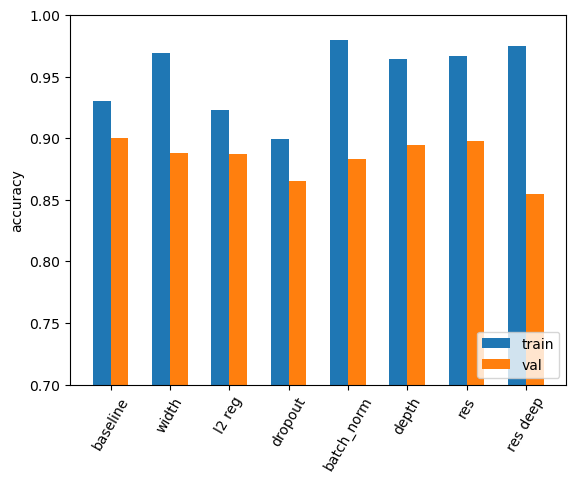

In [53]:
trn_acc = [v['train'] for k, v in all_acc_dict.items()]
val_acc = [v['val'] for k, v in all_acc_dict.items()]

width =0.3
plt.bar(np.arange(len(trn_acc)), trn_acc, width=width, label='train')
plt.bar(np.arange(len(val_acc))+ width, val_acc, width=width, label='val')
plt.xticks(np.arange(len(val_acc))+ width/2, list(all_acc_dict.keys()), rotation=60)
plt.ylabel('accuracy')
plt.legend(loc='lower right')
plt.ylim(0.7, 1)
plt.show()